### Car Insurance Cold Calls
***
#### **Overview**: 
##### This notebook walks through exploratory data analysis (EDA), model training and evaluation of the cold call car insurance campaign.
***
#### **Aim**:
##### Build a classifier to most accurately predict which customer will buy car insurance or not
***
###### ***Notebook Spec***: JupyterLab running a Python 3.7.2 kernel

#### **Note:** If you want a quick summary of each notebook section, skip to the TL;DR summary at the end of each section

In [1]:
# import packages

# user-defined py files
import env
import transforms
import model

# python standard packages
import pandas as pd
import numpy as np
import logging
logging.basicConfig(level=logging.INFO, filename = env.logger_path, format='%(asctime)s - %(levelname)s - %(message)s', datefmt='%Y-%m-%d %H:%M:%S') 
# creating the log file is really only useful in production - in a notebook, print statements make more sense but wanted show that it is important
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize': (12, 8)}) # set plotting params
from scipy.stats import chi2_contingency
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import xgboost as xgb 

In [2]:
# import train and test data
df_train = pd.read_csv(env.train_data)
df_test = pd.read_csv(env.test_data)
logging.info('train and test data read in')

## Exploratory Data Analysis 

##### First, let's explore the data 

In [3]:
# view list of vars in train data
df_train.dtypes, df_train.shape

(Id                   int64
 Age                  int64
 Job                 object
 Marital             object
 Education           object
 Default              int64
 Balance              int64
 HHInsurance          int64
 CarLoan              int64
 Communication       object
 LastContactDay       int64
 LastContactMonth    object
 NoOfContacts         int64
 DaysPassed           int64
 PrevAttempts         int64
 Outcome             object
 CallStart           object
 CallEnd             object
 CarInsurance         int64
 dtype: object, (4000, 19))

In [4]:
# view first few rows, id = Id, target variable = CarInsurance
df_train.head()

,Id,Age,Job,Marital,Education,Default,Balance,HHInsurance,CarLoan,Communication,LastContactDay,LastContactMonth,NoOfContacts,DaysPassed,PrevAttempts,Outcome,CallStart,CallEnd,CarInsurance
0,1,32,management,single,tertiary,0,1218,1,0,telephone,28,jan,2,-1,0,NaN,13:45:20,13:46:30,0
1,2,32,blue-collar,married,primary,0,1156,1,0,NaN,26,may,5,-1,0,NaN,14:49:03,14:52:08,0
2,3,29,management,single,tertiary,0,637,1,0,cellular,3,jun,1,119,1,failure,16:30:24,16:36:04,1
3,4,25,student,single,primary,0,373,1,0,cellular,11,may,2,-1,0,NaN,12:06:43,12:20:22,1
4,5,30,management,married,tertiary,0,2694,0,0,cellular,3,jun,1,-1,0,NaN,14:35:44,14:38:56,0


In [5]:
# quick inspect of the train data, include all data types
include_vars =['object', 'float', 'int']
df_train.describe(include = include_vars)

,Id,Age,Job,Marital,Education,Default,Balance,HHInsurance,CarLoan,Communication,LastContactDay,LastContactMonth,NoOfContacts,DaysPassed,PrevAttempts,Outcome,CallStart,CallEnd,CarInsurance
count,4000.000000,4000.000000,3981,4000,3831,4000.000000,4000.000000,4000.00000,4000.000000,3098,4000.000000,4000,4000.000000,4000.000000,4000.000000,958,4000,4000,4000.000000
unique,NaN,NaN,11,3,3,NaN,NaN,NaN,NaN,2,NaN,12,NaN,NaN,NaN,3,3777,3764,NaN
top,NaN,NaN,management,married,secondary,NaN,NaN,NaN,NaN,cellular,NaN,may,NaN,NaN,NaN,failure,17:11:04,10:22:30,NaN
freq,NaN,NaN,893,2304,1988,NaN,NaN,NaN,NaN,2831,NaN,1049,NaN,NaN,NaN,437,3,3,NaN
mean,2000.500000,41.214750,NaN,NaN,NaN,0.014500,1532.937250,0.49275,0.133000,NaN,15.721250,NaN,2.607250,48.706500,0.717500,NaN,NaN,NaN,0.401000
std,1154.844867,11.550194,NaN,NaN,NaN,0.119555,3511.452489,0.50001,0.339617,NaN,8.425307,NaN,3.064204,106.685385,2.078647,NaN,NaN,NaN,0.490162
min,1.000000,18.000000,NaN,NaN,NaN,0.000000,-3058.000000,0.00000,0.000000,NaN,1.000000,NaN,1.000000,-1.000000,0.000000,NaN,NaN,NaN,0.000000
25%,1000.750000,32.000000,NaN,NaN,NaN,0.000000,111.000000,0.00000,0.000000,NaN,8.000000,NaN,1.000000,-1.000000,0.000000,NaN,NaN,NaN,0.000000
50%,2000.500000,39.000000,NaN,NaN,NaN,0.000000,551.500000,0.00000,0.000000,NaN,16.000000,NaN,2.000000,-1.000000,0.000000,NaN,NaN,NaN,0.000000
75%,3000.250000,49.000000,NaN,NaN,NaN,0.000000,1619.000000,1.00000,0.000000,NaN,22.000000,NaN,3.000000,-1.000000,0.000000,NaN,NaN,NaN,1.000000


In [6]:
# count the nulls in each column
df_train.isnull().sum(axis = 0)

Id                     0
Age                    0
Job                   19
Marital                0
Education            169
Default                0
Balance                0
HHInsurance            0
CarLoan                0
Communication        902
LastContactDay         0
LastContactMonth       0
NoOfContacts           0
DaysPassed             0
PrevAttempts           0
Outcome             3042
CallStart              0
CallEnd                0
CarInsurance           0
dtype: int64

#### Observations
At a glance, the training data contains 19 variables and 4k rows. Each row represents contacting a member about car insurance. There is **demographic** information like age, job and education status. There is more specific **bank information** like average annual balance, whether they have defaulted and if they have other bank products. Finally, there is information about **marketing campaigns** and if they have successfully sold them car insurance. The data were well populated except for `Outcome`, `Job`, `Education` and `Communication`. Imputation will need to be considered for these variables. **Target:** `CarInsurance`. 

Next it is useful to 
1. Inspect the variables' distribution (univariate analysis)
2. Test for multicollinearity
3. Test the relationship with the target variable (bivariate analysis).

#### 1. Inspect the variables' distributions, starting with numeric data

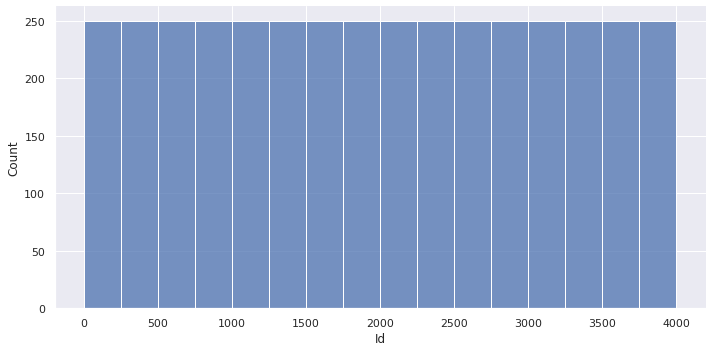

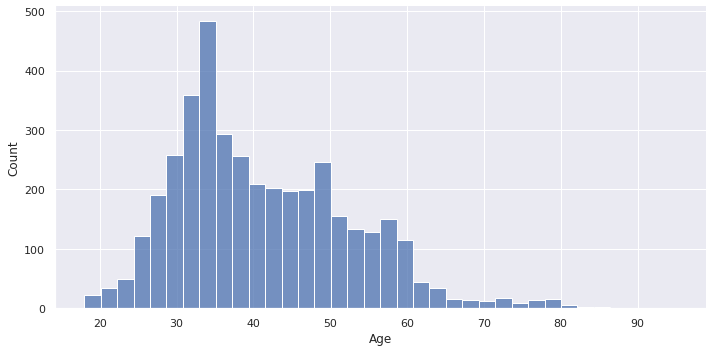

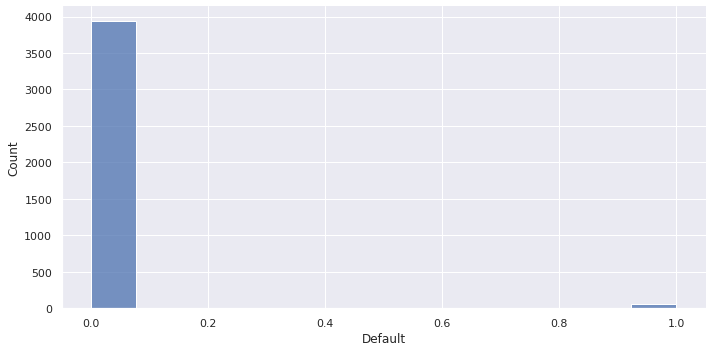

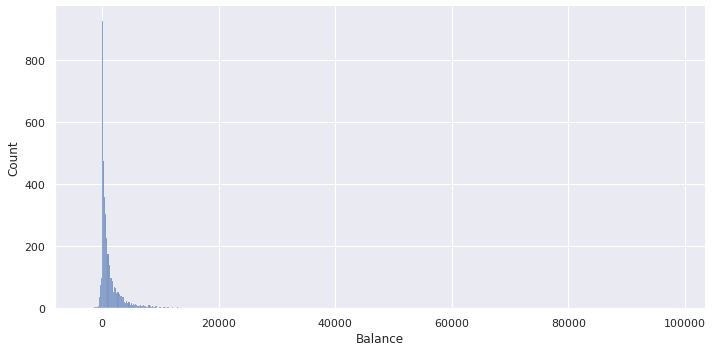

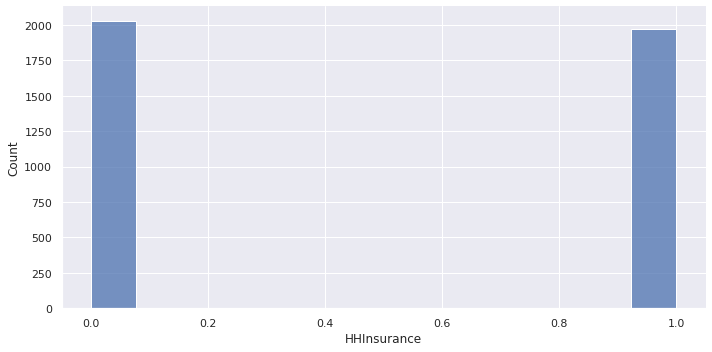

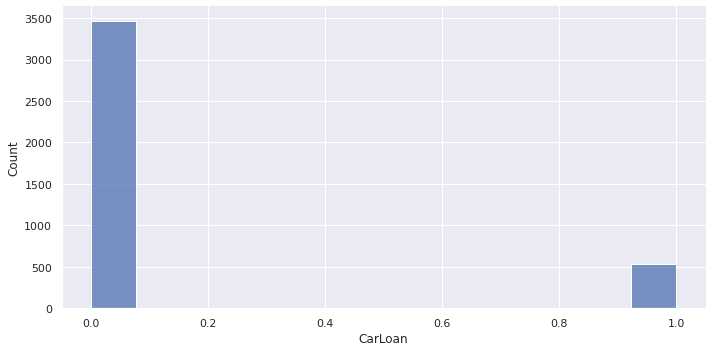

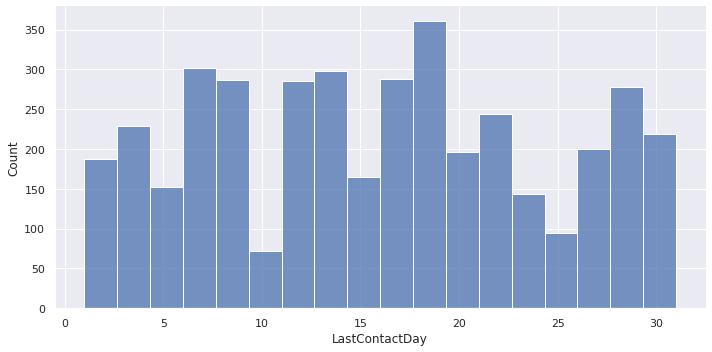

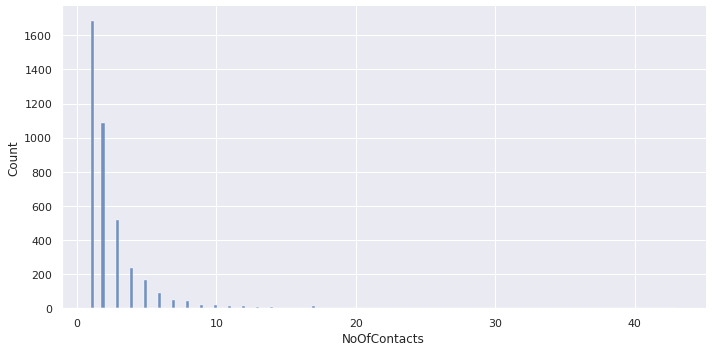

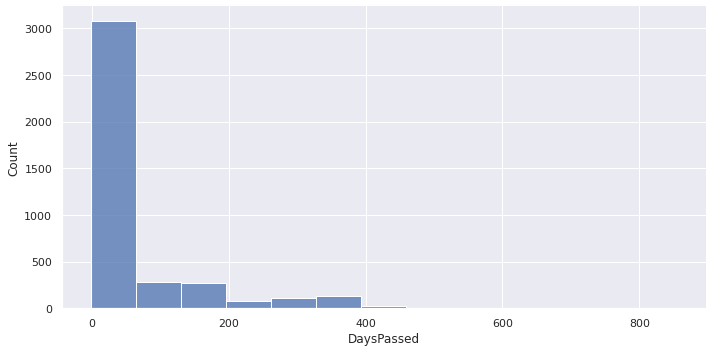

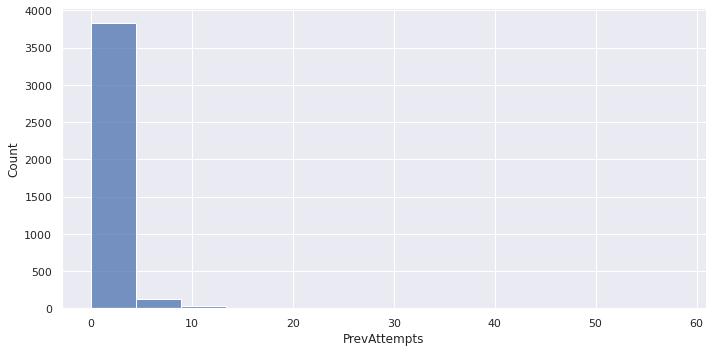

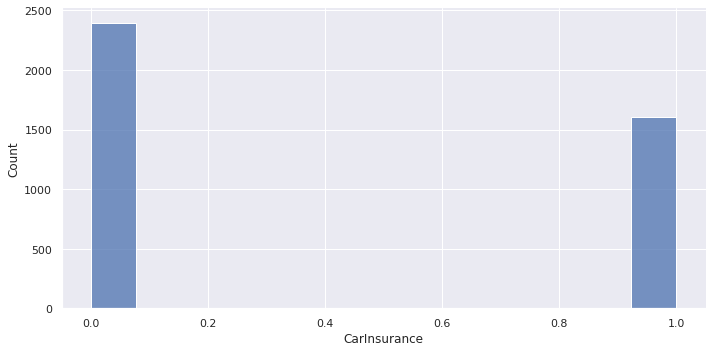

In [7]:
# get numeric variables only and create new df
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df_num = df_train.select_dtypes(include=numerics)

# get distributions 
for col in df_num.columns:
    sns.displot(x = df_num[col], height = 5, aspect = 2)
    plt.show()

#### View the categorical variables' bar plot


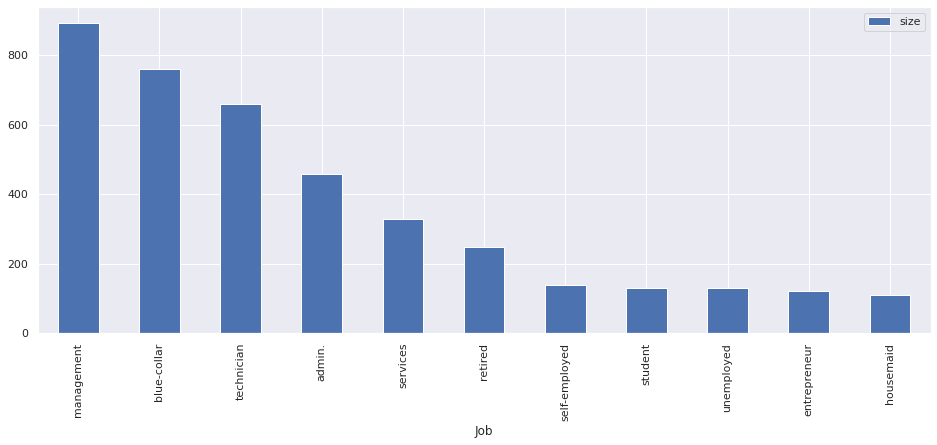

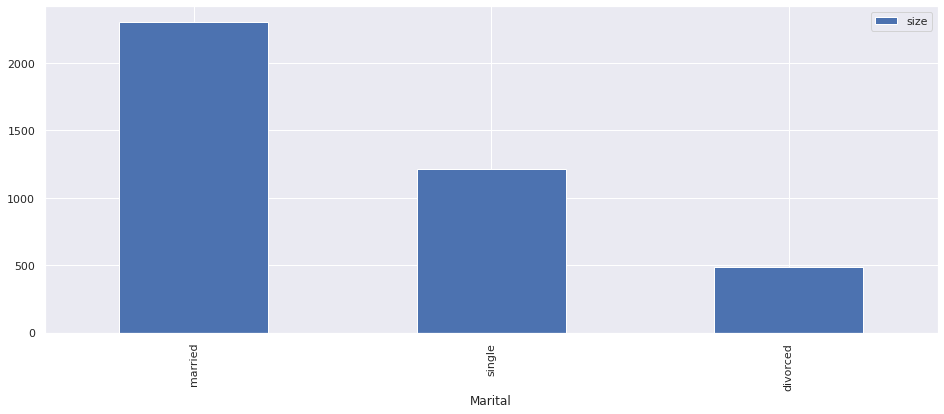

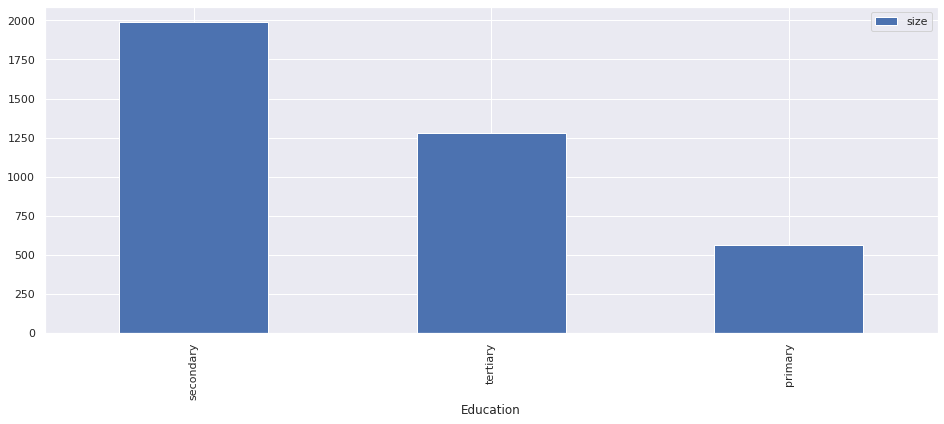

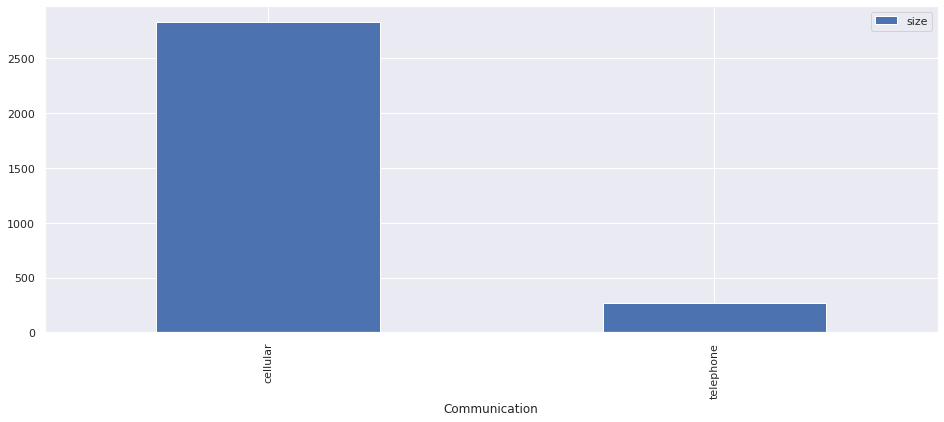

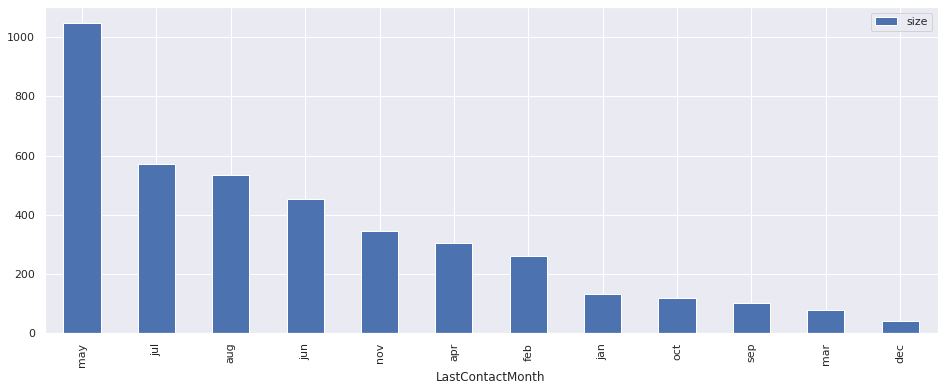

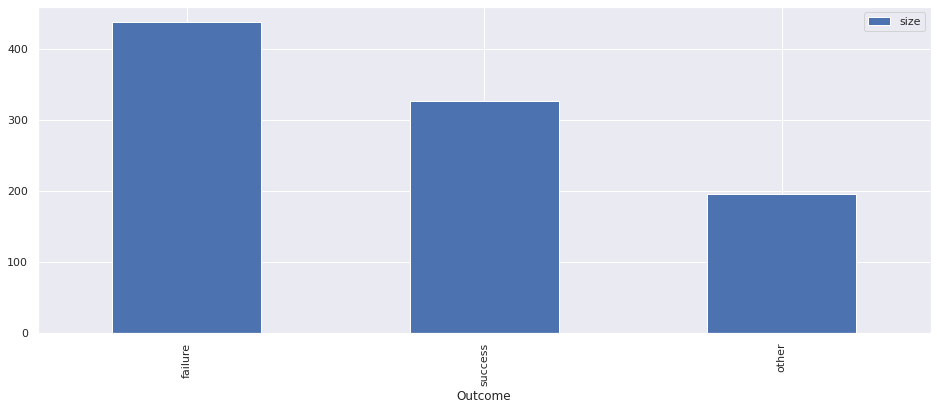

In [8]:
# create categorical dataframe
df_cat = df_train.select_dtypes(exclude=numerics)

# drop CallStart and CallEnd vars because of their high uniqueness
df_cat2 = df_cat.drop(['CallStart', 'CallEnd'], axis = 1)
for col in df_cat2.columns:
    grpd = df_cat2.groupby([col]).size().to_frame('size').reset_index()
    res = grpd.sort_values(by='size', ascending = False)
    res.plot(kind = 'bar', x = res.columns[0], figsize = (16,6))
    plt.show()

#### Univariate Observations
##### **Numerical Data**
- The `Id` var is obviously a useless predictive feature and will not be used in the model
- Many of the numerical variables are right-skewed (`Age`, `Balance`, `NoOfContacts`) and may need to be transformed or have the outliers removed
- Vars that describe previous campaigns contain imputed values e.g. `DaysPassed`
- There is a class imbalance in the target variable and may need to be resampled for model build, and/or can specifically focus on tree-based models only
- There are binary variables in the numerical data - `Default`, `HHInsurance`, `CarLoan`

##### **Categorical Data**
- `LastContactMonth` is oddly high for month of May but may be due to sampling 
- Most of the data falls into the Cellular category for `Communication` var so may have poor predictive power

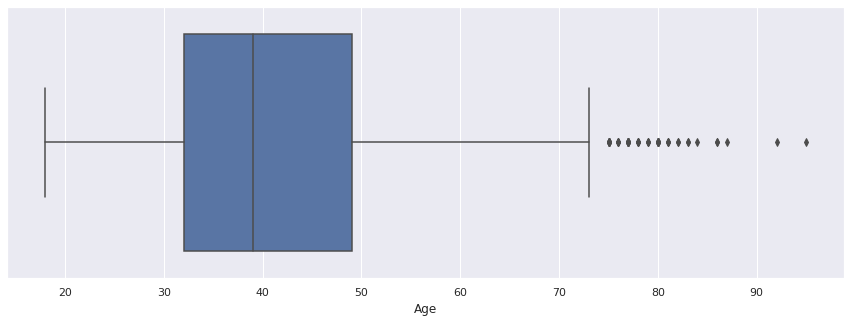

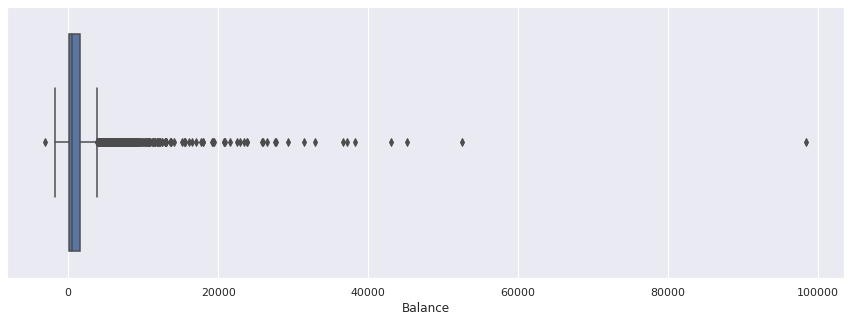

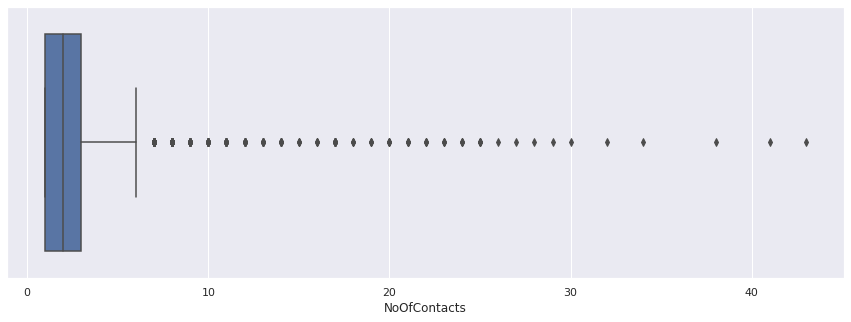

In [9]:
# check if outliers exist using box plots
check_cols = ['Age', 'Balance', 'NoOfContacts']
for col in df_train[check_cols]:
    sns.set(rc={'figure.figsize':(15,5)})
    sns.boxplot(x = df_train[col] )
    plt.show()

There were outliers in all three variables but there was an extreme outlier in the `Balance` variable. Since there was no scarity of data, the observation can be removed. The other observations can remain in the data for now. If model performance is poor, we can identify the predictions for these observations and check if they are being misclassified

(3999, 20)


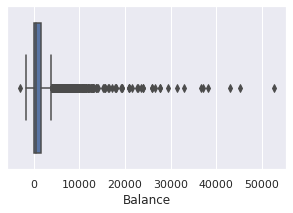

In [37]:
# find index of the large value
idx = df_train.index[df_train['Balance'] > 90000].tolist()

# delete row from table
df_train.drop(idx, axis = 0, inplace = True)
print(df_train.shape)
logging.info('outliers removed')

# replot the data to check this effect
sns.boxplot(x = df_train['Balance'])
plt.show()

Can now see that the x-axis is much smaller in its range after the extreme outlier has been removed

#### 2. Test for multicollinearity
#### 3. Test the relationship with the target variable

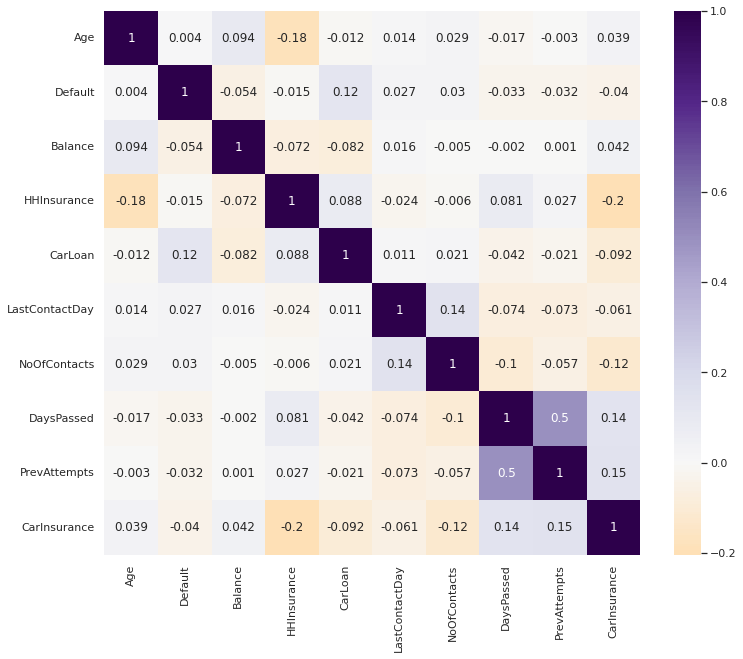

In [11]:
# linear correlation (multicollinearity)
# create linear correlation matrix, drop the Id var and round to 3 decimal places
corr_mat = df_num.corr('pearson')
corr_mat2 = corr_mat.drop(['Id'],axis=1).drop(['Id'],axis = 0).round(3)

# create plot
sns.set(rc={'figure.figsize':(12,10)})
sns.heatmap(data=corr_mat2, vmax=1, annot = True, cmap="PuOr", center=0 )
plt.show()

- `DaysPassed` and `PrevAttempts` look correlated. This makes sense since both vars describe previous campaigns. Vast majority (>75%) of the customers in this data were not previously contacted so expect these two vars to be correlated for these customers. Need to consider how to handle these variables
- `PrevAttempts` and `DaysPassed` were positively correlated (weak) with the target - is this because they were longer with the bank and have better engagement with the bank?
- `HHInsurance` was negatively correlated (weak) with the target - is this because they have already bundled car and home insurance?
- The remaining variables have a very weak relationship with the target

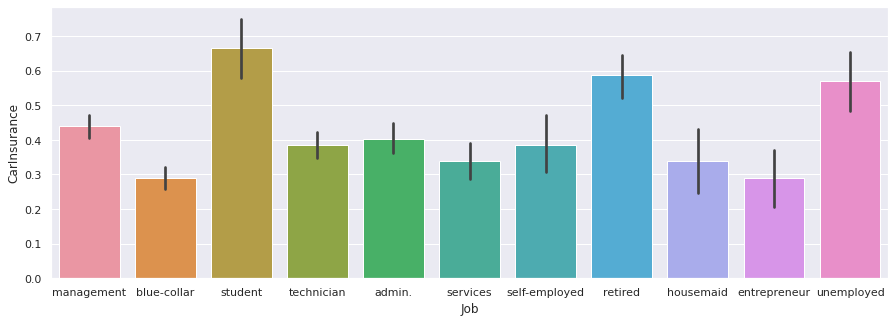

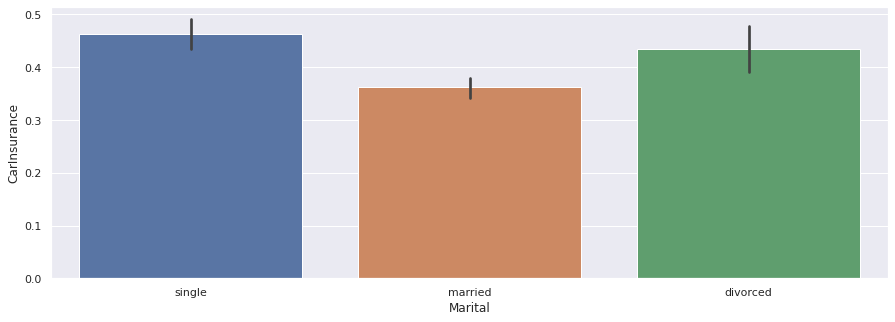

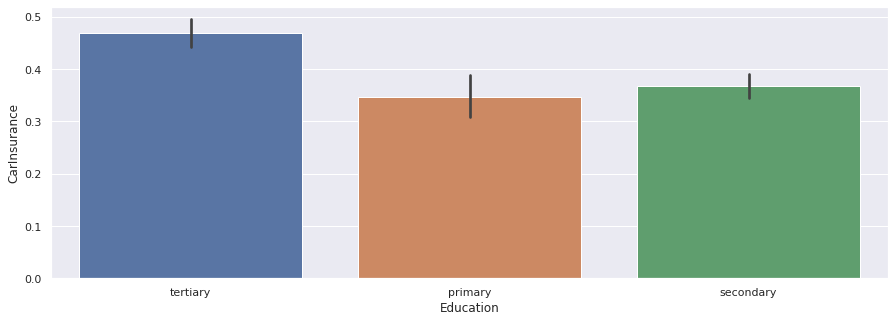

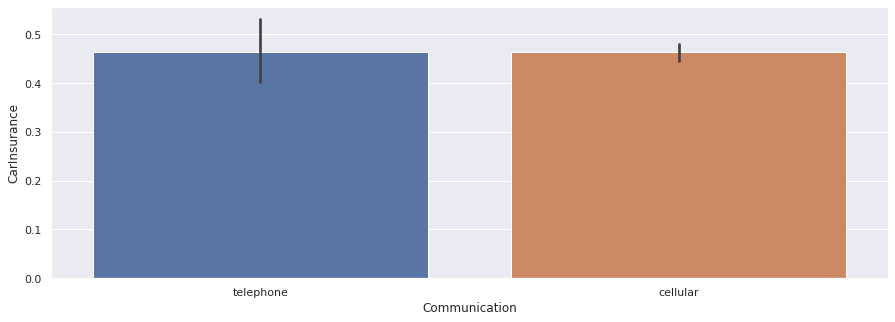

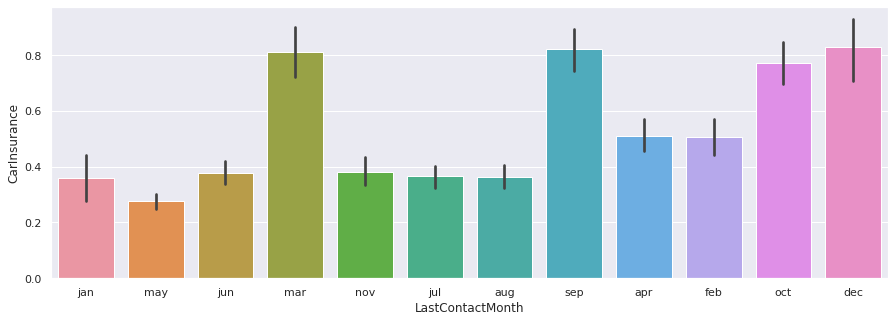

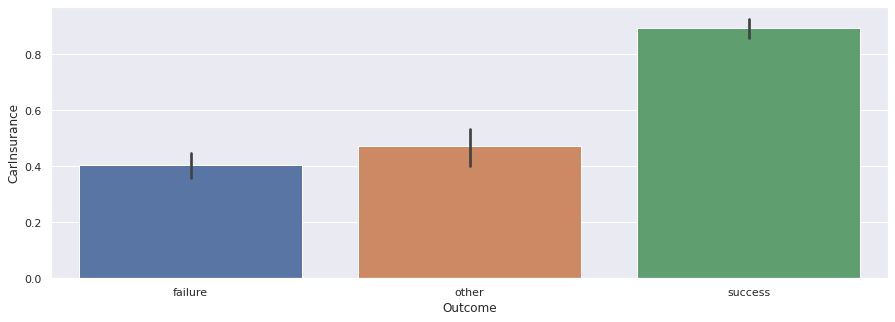

In [12]:
# examine the categorical features
for col in df_cat2.columns:
    plt.figure(figsize=(15,5))
    sns.barplot(x = col, y = 'CarInsurance', data=df_train) 

The above plots show the mean of `CarInsurance` on the y-axis and the different categories for the variable on the x-axis. 
- `Job`: Students and the retired were likely to buy car insurance compared to other occupations
- `Outcome`: Customers who were successfully part of a previous marketing campaign were very likely to buy car insurance
- `Education`: Customers who have studied at a third level were more likely to buy car insurance compared to other levels.
- `Communication`: Looks like  `mean(CarInsurance)` is identical across telephone and cellular. Let's use a chi-square test to check if there is a significant difference between both categories - if not, `Communication` will be dropped

In [13]:
# check if communication var is worth keeping
# typically, if we have many variables, this would be an automated test, running through all stats that would output a list of significant vars
# worth keeping for model build
group_data = df_train.groupby(['CarInsurance', 'Communication']).size().unstack('CarInsurance')
chisq_stats, chisq_pvalue, chisq_dof, chisq_expctd = chi2_contingency(group_data)
print('The chi-square value for Communication and CarInsurance is {} and the p-value is {}'.format(chisq_stats, chisq_pvalue))

The chi-square value for Communication and CarInsurance is 0.0004371138594676448 and the p-value is 0.9833196287856788


Since the p-value > 0.05, do not reject the null hypothesis that no relationship exists on the categorical variables, `CarInsurance` and `Communication` 

## TL;DR
## Exploratory Data Analysis - Summary 
Below is a summary of findings and actions from EDA
1. The target variable, CarInsurance, is imbalanced. **Action:** consider oversampling to create a balanced class
2. One training obs was removed due to extremely high values in `Balance`. **Action:** none - already removed
3. There are missing values `Outcome`, `Job`, `Education` and `Communication`. **Action:** consider imputation strategies

**Numeric vars:** 
1. There were weak positive and negative relationships with the target. **Action:** consider feature engineering to build more powerful features 
2. There are binary variables in the numerical data - `Default`, `HHInsurance`, `CarLoan` **Action:** no action
3. DaysPassed and PrevAttempts are linearly correlated. **Action:** consider dropping one of the cols 

**Categorical vars:** 
1. There are obvious differences among the categories
2. The categorical variables will need to be encoded (one hot, ordinal or otherwise) for model build. **Action:** consider encoding best practices for each categorical variable
2. `Communication` has no relationship with the target **Action:** drop this variable

## Feature Engineering

##### First, let's drop unneccesary vars

In [14]:
# drop vars
df_train.drop(['Communication'], axis = 1, inplace = True)
logging.info('dropped Communication variable in train data')

##### Next, let's impute the missing values

In [15]:
# impute missing values according to what is most appropriate for the variable itself
# Communication: this is dropped, no imputation required
# Outcome: missing related to no previous campaigns, impute with no previous campaign value
# Job: impute with mode
# Education: impute with mode
df_train_imp = transforms.impute_vars(df_train = df_train)
logging.info('train data imputed')

##### Next, let's engineer more features
##### Strategy:
1. `Age` will be kept as continuous variable but consider binning if model performance is poor
2. `Job` will need to be encoded
3. `Education` will need to be encoded - try using an ordinal encoder
4. `Marital` will need to be encoded - dummy
5. `Default` is a binary field
6. `Balance` will be kept as continuous variable but consider binning if model performance is poor
7. `HHInsurance` binary field
8. `CarLoan` binary field
9. `LastContactDay` will be kept as an int
10. `LastContactMonth` will need to be encoded - dummy
11. `NoOfContacts` will stay as int
12. `DaysPassed` will stay as int
13. `PrevAttempts` will stay as int
14. `Outcome` will be encoded - dummy
15. `CallStart` and `CallEnd` will be used to calculate call duration

In [16]:
# create base table for modelling and feature extraction, based on what is explained above
df_base = transforms.get_features(df_train_imp)
logging.info('feature engineering on train data complete')

(3999, 43)


In [17]:
df_base.dtypes

Id                         int64
Age                        int64
Default                    int64
Balance                    int64
HHInsurance                int64
CarLoan                    int64
LastContactDay             int64
NoOfContacts               int64
DaysPassed                 int64
PrevAttempts               int64
CarInsurance               int64
EducationEncoded           int64
CallDuration             float64
Job_admin.                 uint8
Job_blue-collar            uint8
Job_entrepreneur           uint8
Job_housemaid              uint8
Job_management             uint8
Job_retired                uint8
Job_self-employed          uint8
Job_services               uint8
Job_student                uint8
Job_technician             uint8
Job_unemployed             uint8
Marital_divorced           uint8
Marital_married            uint8
Marital_single             uint8
LastContactMonth_apr       uint8
LastContactMonth_aug       uint8
LastContactMonth_dec       uint8
LastContac

## TL;DR
## Feature Engineering - Summary 
- Input: 3,999 rows with 20 variables. Output: 3,999 rows with 43 variables, including an ID var
- Removed redundant feature, `Communication`
- One hot encoding is the most basic way of handling dummy variables. May be more useful to try different methods like grouping categroies based on their relationship with the target, time permitting
- Binning of continuous variables could also be experimented, time permitting
- TODO: create a class for feature engineering and embed all functions as instance methods within the class, time permitting


## Model build 

##### There are 41 features available to predict whether or not a customer will buy car insurance
##### **Note** `CallDuration` could be a variable with leakage. If we are trying to identify which customers to call, then the call would not have happened yet, so there would be no `CallStart` or `CallEnd` information. This feature will remain in the data though, as I think it is beyond the scope of this exercise :) 

##### **Strategy**
- Split data: Since the test data is missing outcomes for `CarInsurance`, the train data needs to split into train and test to assess for true model performance. CV will be used so no need to create validation set
- Balance class in target variable in the train data (may be overkill since the imbalance isn't too severe, but is best practice). Should be completed after the data split so there is no risk of resampled observations being in both train and test data (TODO)
- Build baseline model (vanilla logistic regression with no hyperparameter tuning) 
- Build multiple challenger models (random forest, gbm, xgboost). Deep neural networks will not be explored because the data volume is relatively low and the data is in tabular format. Xgboost is likely going to beat them all!
- Pick champion model based on best validation performing metrics for scoring new observations
- Score unseen data with champion model

In [18]:
# create balanced dataframe for model build
# there are more methods like SMOTE and undersampling that could be tested too. These are less desirable since under-sampling loses information about
# the targe class and SMOTE create artifical observations which may not be reflective
#df_base_bal = transforms.oversample(df_base)
#df_base_bal.shape
#logging.info('balanced class created in train data')

In [19]:
# check the differences in class balance between both data sets
#df_base.groupby('CarInsurance').size(), df_base_bal.groupby('CarInsurance').size()

In [20]:
# split data
x_train, x_test, y_train, y_test = model.data_split(df_base)

#### Model Development

In [21]:
# cols for feature importance
idx_cols = df_base.drop(['CarInsurance', 'Id'], axis = 1).columns

#### Scoring metric
For this problem, I chose recall as the scoring metric for model assessment. Since it is a revenue generating campaign, it is best to identify as many successful car insurance sales as possible (i.e. reduce the number of false negatives) in order to generate the most revenue. I think missing a successful car insurance upsell/cross sell would have more impact on the business than calling a customer who does not want to buy car insurance (i.e. false positives is not the main concern). Of course, the business leaders and SMEs will ultimately help decide which approach is better - cold calling lots of customers may lead to poor NPS ratings and churn...

Other performance assessment metrics could be considered too like accuracy, precision and AUC but were omitted for now.

Fitting 5 folds for each of 1 candidates, totalling 5 fits
DecisionTreeClassifier()
CV Recall is 0.7203730158730158
Test Recall is 0.6777546777546778


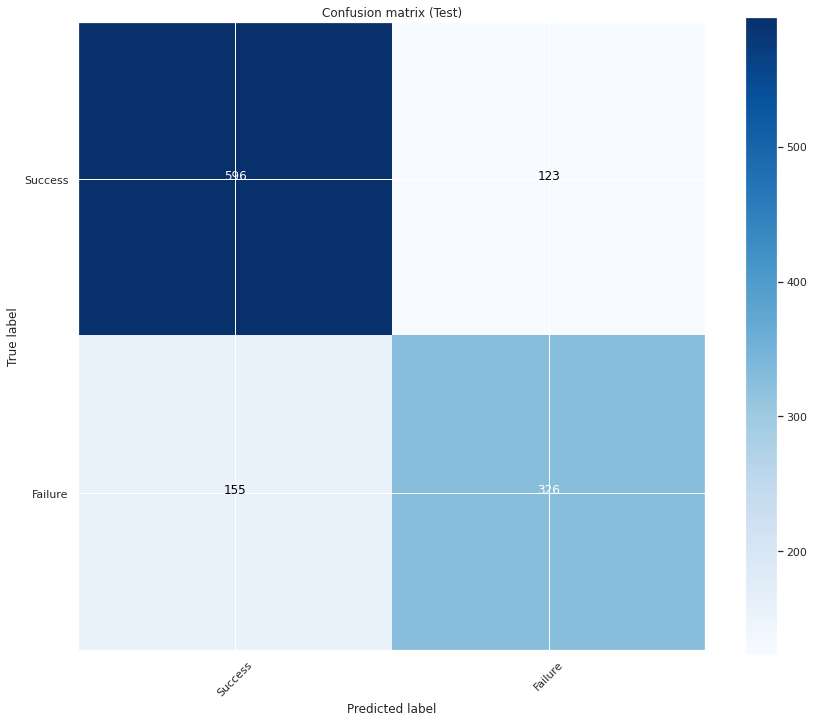

In [33]:
# baseline model - vanilla decision tree
dt = DecisionTreeClassifier()

# define params - none as it is a vanilla model
dt_params = {}

# get model and best score (mean cross-validated score)
baseline_model, baseline_best_score = model.get_best_model(x_train, y_train, estimator = dt, model_name = 'dt', param_grid = dt_params)
print('CV Recall is {}'.format(baseline_best_score))

# get confusion matrix and feature importances
model.model_fit(x_train, y_train, x_test, y_test, cols = idx_cols, model = baseline_model, show_ft_imp = False)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
RandomForestClassifier(max_depth=7, random_state=0)
CV Recall is 0.7265396825396826
Test Recall is 0.760914760914761


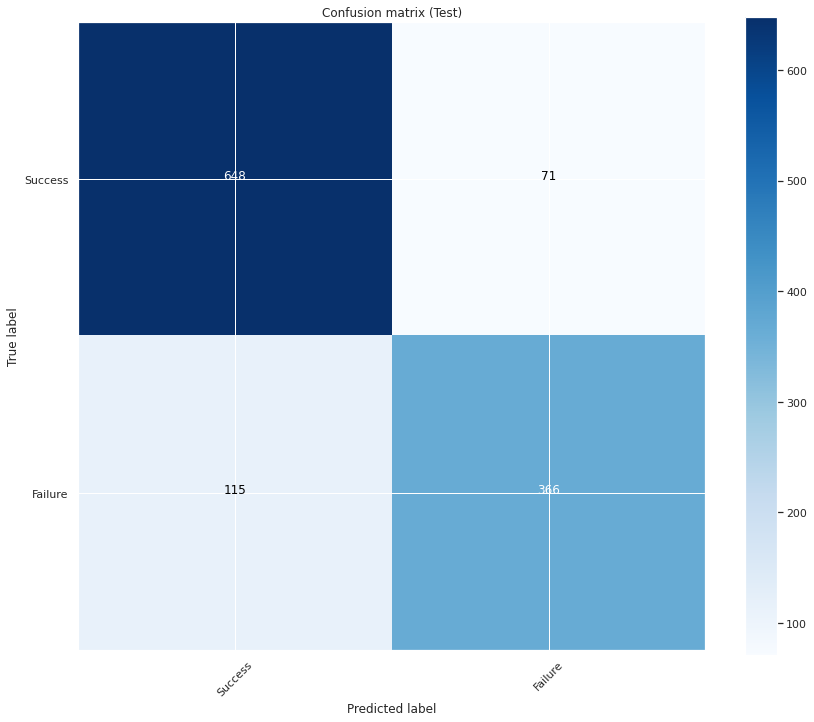

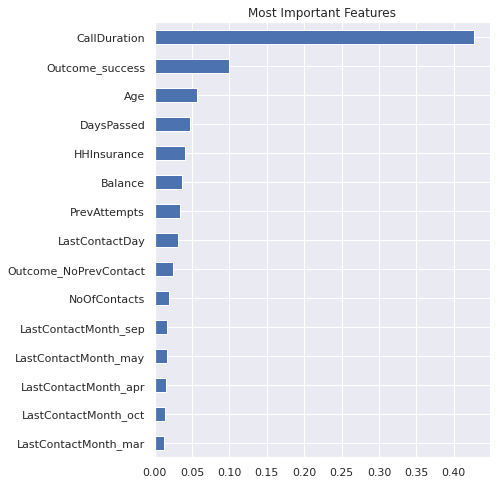

In [34]:
# random forest model
rf = RandomForestClassifier()

# define params - none as it is a vanilla model
rf_params =  {'n_estimators':[100,200,250,300],
               'max_depth':list(range(4,8)),
               #'min_samples_leaf':list(range(10)),
               #'min_samples_split':list(range(2,10)),
               'random_state':[0]}

# get model and best score (mean cross-validated score)
rf_model, rf_best_score = model.get_best_model(x_train, y_train, estimator = rf, model_name = 'rf', param_grid = rf_params)
print('CV Recall is {}'.format(rf_best_score))

# get confusion matrix and feature importances
model.model_fit(x_train, y_train, x_test, y_test, cols = idx_cols, model = rf_model, show_ft_imp = True)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
GradientBoostingClassifier(learning_rate=0.2, loss='exponential', max_depth=4,
                           random_state=0)
CV Recall is 0.8004563492063491
Test Recall is 0.8004158004158004


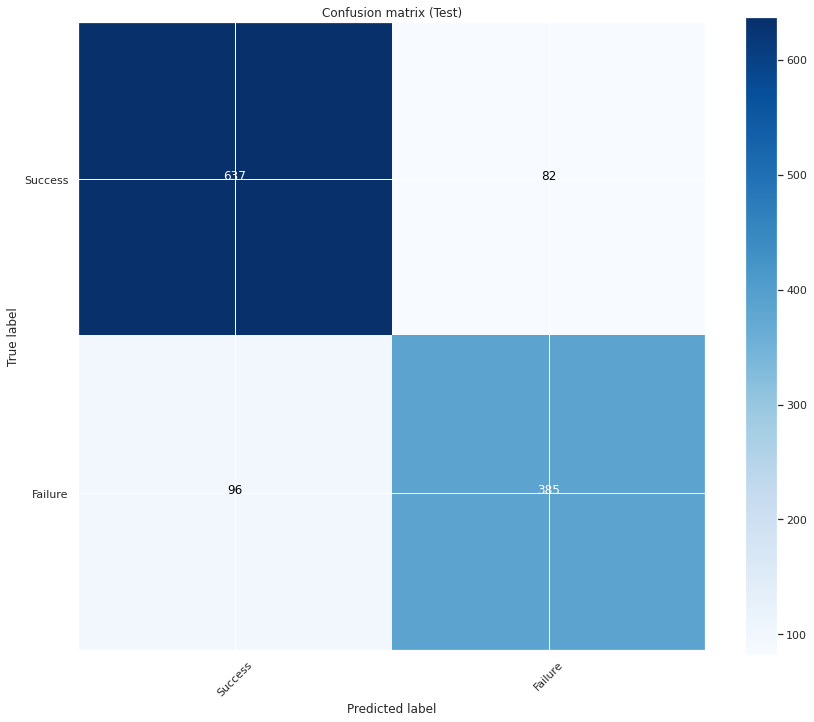

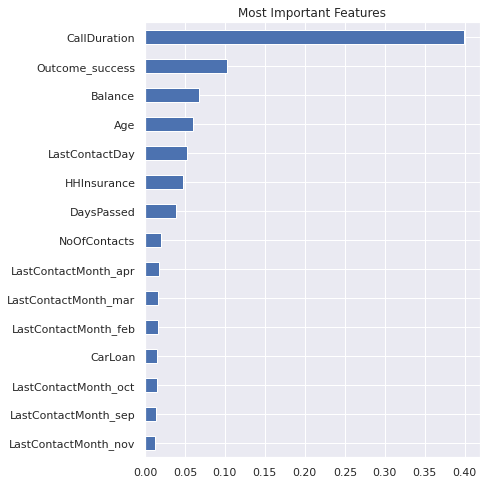

In [24]:
# gbm model
gbm = GradientBoostingClassifier()

# grid search for gbm
gbm_params = {'loss':['deviance', 'exponential'],
               'n_estimators':[100, 200, 300],
               'max_depth':list(range(4,8)),
               #'min_samples_leaf':list(range(3,5)),
               #'min_samples_split':list(range(2,10)),
               'random_state':[0],
               'learning_rate':[0.05, 0.1, 0.2, 0.5]}


# get model and best score (mean cross-validated score)
gbm_model, gbm_best_score = model.get_best_model(x_train, y_train, estimator = gbm, model_name = 'gbm', param_grid = gbm_params)
print('CV Recall is {}'.format(gbm_best_score))

# get confusion matrix and feature importances
model.model_fit(x_train, y_train, x_test, y_test, cols = idx_cols, model = gbm_model, show_ft_imp = True)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
AdaBoostClassifier(base_estimator=RandomForestClassifier(max_depth=7,
                                                         random_state=0),
                   learning_rate=0.05, n_estimators=200, random_state=0)
CV Recall is 0.8004801587301588
Test Recall is 0.8045738045738046


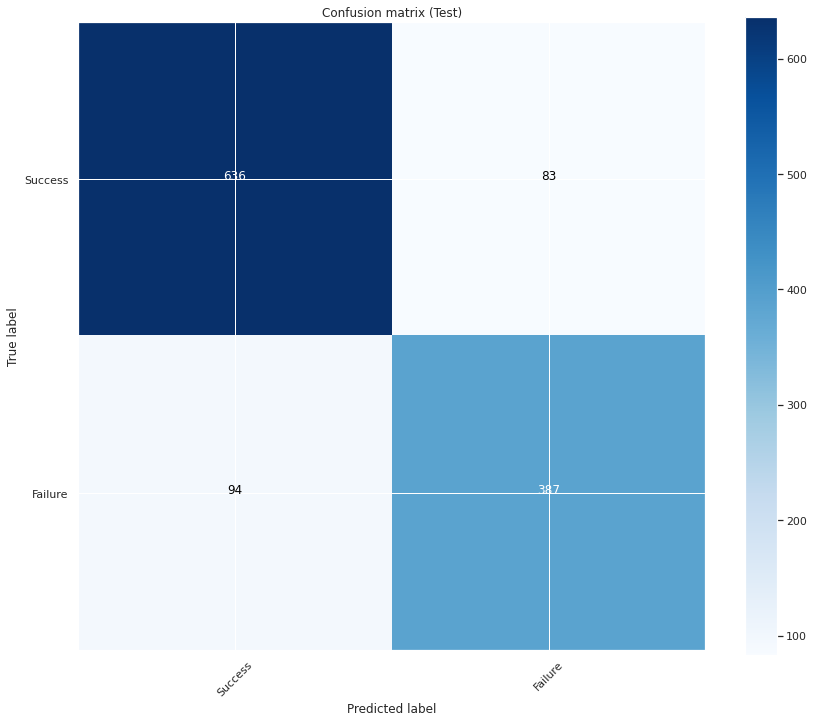

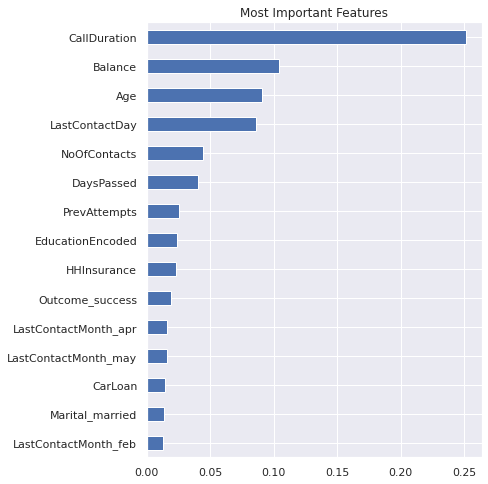

In [25]:
# adaboost model
ada = AdaBoostClassifier()

# grid search for gbm
ada_params = {'base_estimator':[rf, gbm_model, rf_model],
               'n_estimators':[100, 200, 300],
               #'min_samples_leaf':list(range(3,5)),
               #'min_samples_split':list(range(2,10)),
               'random_state':[0],
               'learning_rate':[0.05, 0.1, 0.2, 0.5]}

# get model and best score (mean cross-validated score)
ada_model, ada_best_score = model.get_best_model(x_train, y_train, estimator = ada, model_name = 'ada', param_grid = ada_params)
print('CV Recall is {}'.format(ada_best_score))

# get confusion matrix and feature importances
model.model_fit(x_train, y_train, x_test, y_test, cols = idx_cols, model = ada_model, show_ft_imp = True)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
XGBClassifier(alpha=0.5, base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0.5, ...)
CV Recall is 0.805809523809524
Test Recall is 0.8045738045738046


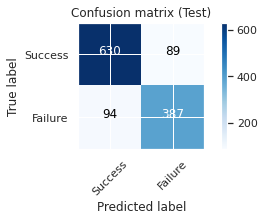

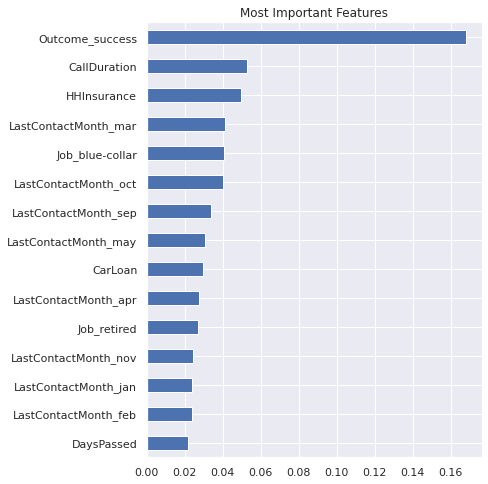

In [42]:
# xgboost
xg = xgb.XGBClassifier()

# grid search for xgboost model
xg_params = { 'objective':['binary:logistic'], 
                'alpha':[0, 0.1, 0.5],
                'n_estimators':[100, 200, 250],
                'max_depth':list(range(4, 8)),
                'seed':[0],
                'subsample':[0.5, 0.75], # sample data before growing trees
                'learning_rate':[0.05, 0.1, 0.3]}

# get model and best score (mean cross-validated score)
xg_model, xg_best_score = model.get_best_model(x_train, y_train, estimator = xg, model_name = 'xgb', param_grid = xg_params)
print('CV Recall is {}'.format(xg_best_score))

# get confusion matrix and feature importances
model.model_fit(x_train, y_train, x_test, y_test, cols = idx_cols, model = xg_model, show_ft_imp = True)

#### Champion Model Selection TODO
Using the CV Recall metric, the XGBoost model is the best performing model with a Recall of **0.806**. Its just pips the GBM and AdaBoost model. Its Test Recall (i.e. true model performance) is **0.805** with little evidence of overfitting. Therefore, the XGBoost model is selected as the champion model. Below are the details of the best performing GBM model. This model will be used to score new data

In [46]:
xg_model.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': False,
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.1,
 'max_bin': 256,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 5,
 'max_leaves': 0,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 200,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0.5,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': 1,
 'subsample': 0.75,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None,
 'alpha': 0.5,
 'seed': 0}

#### Insights
The top 5 features were
1. `Outcome_success`
2. `CallDuration` Note: This is by far the predictor with the most contribution across all models. It could be related to call agents and customers have a productive conversation or, as I mentioned above, it could be leakage due to the customers having to complete the car insurance transaction which will take longer
2. `HHInsurance`
3. `LastContactMonth_mar`
4. `Job_blue-collar`

For meaningful business actions, a good next step is to profile/describe the differences in these variables between the positive and negative class. Then, share these differences with the business/operations teams and derive a plan for business intervention. E.g. `Outcome_success` variable suggests that if the bank was successful with a previous campaign with a customer, they should be contacted again for other campaigns.

## TL;DR
## Model Build, Selection and Assessment 
- The data was split 70:30
- Would have liked to balance the data after splitting as there is imbalance. Nevertheless, the imbalance is not severe and tree-based models handles this well. Furthermore, the accuracy measure was not used for model assessment.
- An exhaustive grid search with cross-validation was used to build and assess multiple tree-based models. The best performing/champion model was selected based on the mean cross-validated recall score. 
- A baseline vanilla decision model was built to highlight the affects of hyperparameter tuning and to see if it was worthwhile
- The champion model was TODO. This was based on model with the highest cross-validated mean recall score
- The best features were 
>1. `Outcome_success` 
>2. `CallDuration`
>3. `HHInsurance`
>4. `LastContactMonth_mar`
>5. `Job_blue-collar`
- Further model evaluation could be performed like looking at lift curves (to examine benefit of using this model)

#### Scoring
##### Use the champion model to score the test data and output into data folder

In [47]:
# transform the test data
# drop vars
df_test2 = df_test.drop(['Communication','CarInsurance'], axis = 1)
logging.info('dropped Communication variable in test data')

# impute missing
df_test_imp = transforms.impute_vars(df_test2)
logging.info('test data imputed')

# create base table for scoring
df_to_score = transforms.get_features(df_test_imp)

# convert to array as expected by the model
ar_to_score = df_to_score.drop('Id',axis = 1).to_numpy()
logging.info('feature engineering on test data complete')

(1000, 42)


In [48]:
# get predictions
preds = xg_model.predict(ar_to_score)
#min_preds = np.amin(preds)
#max_preds = np.amax(preds)
#min_preds, max_preds

In [49]:
# add to output and write out into data
df_preds = pd.DataFrame(preds, columns = ['CarInsurance_Scored'])

df_scored = pd.concat([df_test, df_preds], axis=1)
df_scored.shape
logging.info('test data scored')

In [50]:
# output into data folder
df_scored.to_csv(env.data_path+'scored_carInsurance_test.csv')

## TL;DR
### Summary
- EDA completed
> It highlighted missing values in the data, redundant fields, multicollinearity, outliers and explored relationships between the predictors and target variable.
- Model build completed
> Using an exhaustive grid search approach, multiple tree-based models were built and tested. The best performing model was selected using the cross-validated recall score. The champion model was TODO.
> This model will be used in the rest api app for scoring new data

#### Enhancements
1. Create a feature engineering class that transforms the data that can be called when new data needs to be transformed. Derive more generated features
2. Balance the class before model building (I actually had this completed then realised it was in the wrong order (i.e. balanced then split when it should be split then balanced. Was getting exceptional model results because of leakage!!).
3. Add more parameters as appropriate to the GridSearchCV method to improve model performance
4. Include feature selection methods to reduce the number of variables being used in the models. Especially useful for building generalized linear models like logisitic regression
5. Include lift charts to show the business the impact of using a model can have